# Decomposition of sEMG signals from armband

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import seaborn as sns
import torch

import emgkit
from data_utils import load_armband_signal

logging.basicConfig(level=logging.INFO)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info("Using CUDA version")
else:
    device = torch.device("cpu")
    logging.info("Using CPU version")

sns.set_context("talk")

FS = 4000
SEED = 42
SUBJ = "S1"
DATA_PATH = os.path.join("data", "armband", f"{SUBJ}_isometric.bin")

INFO:root:Using CUDA version


Load the signal, filter it and plot the power spectrum.

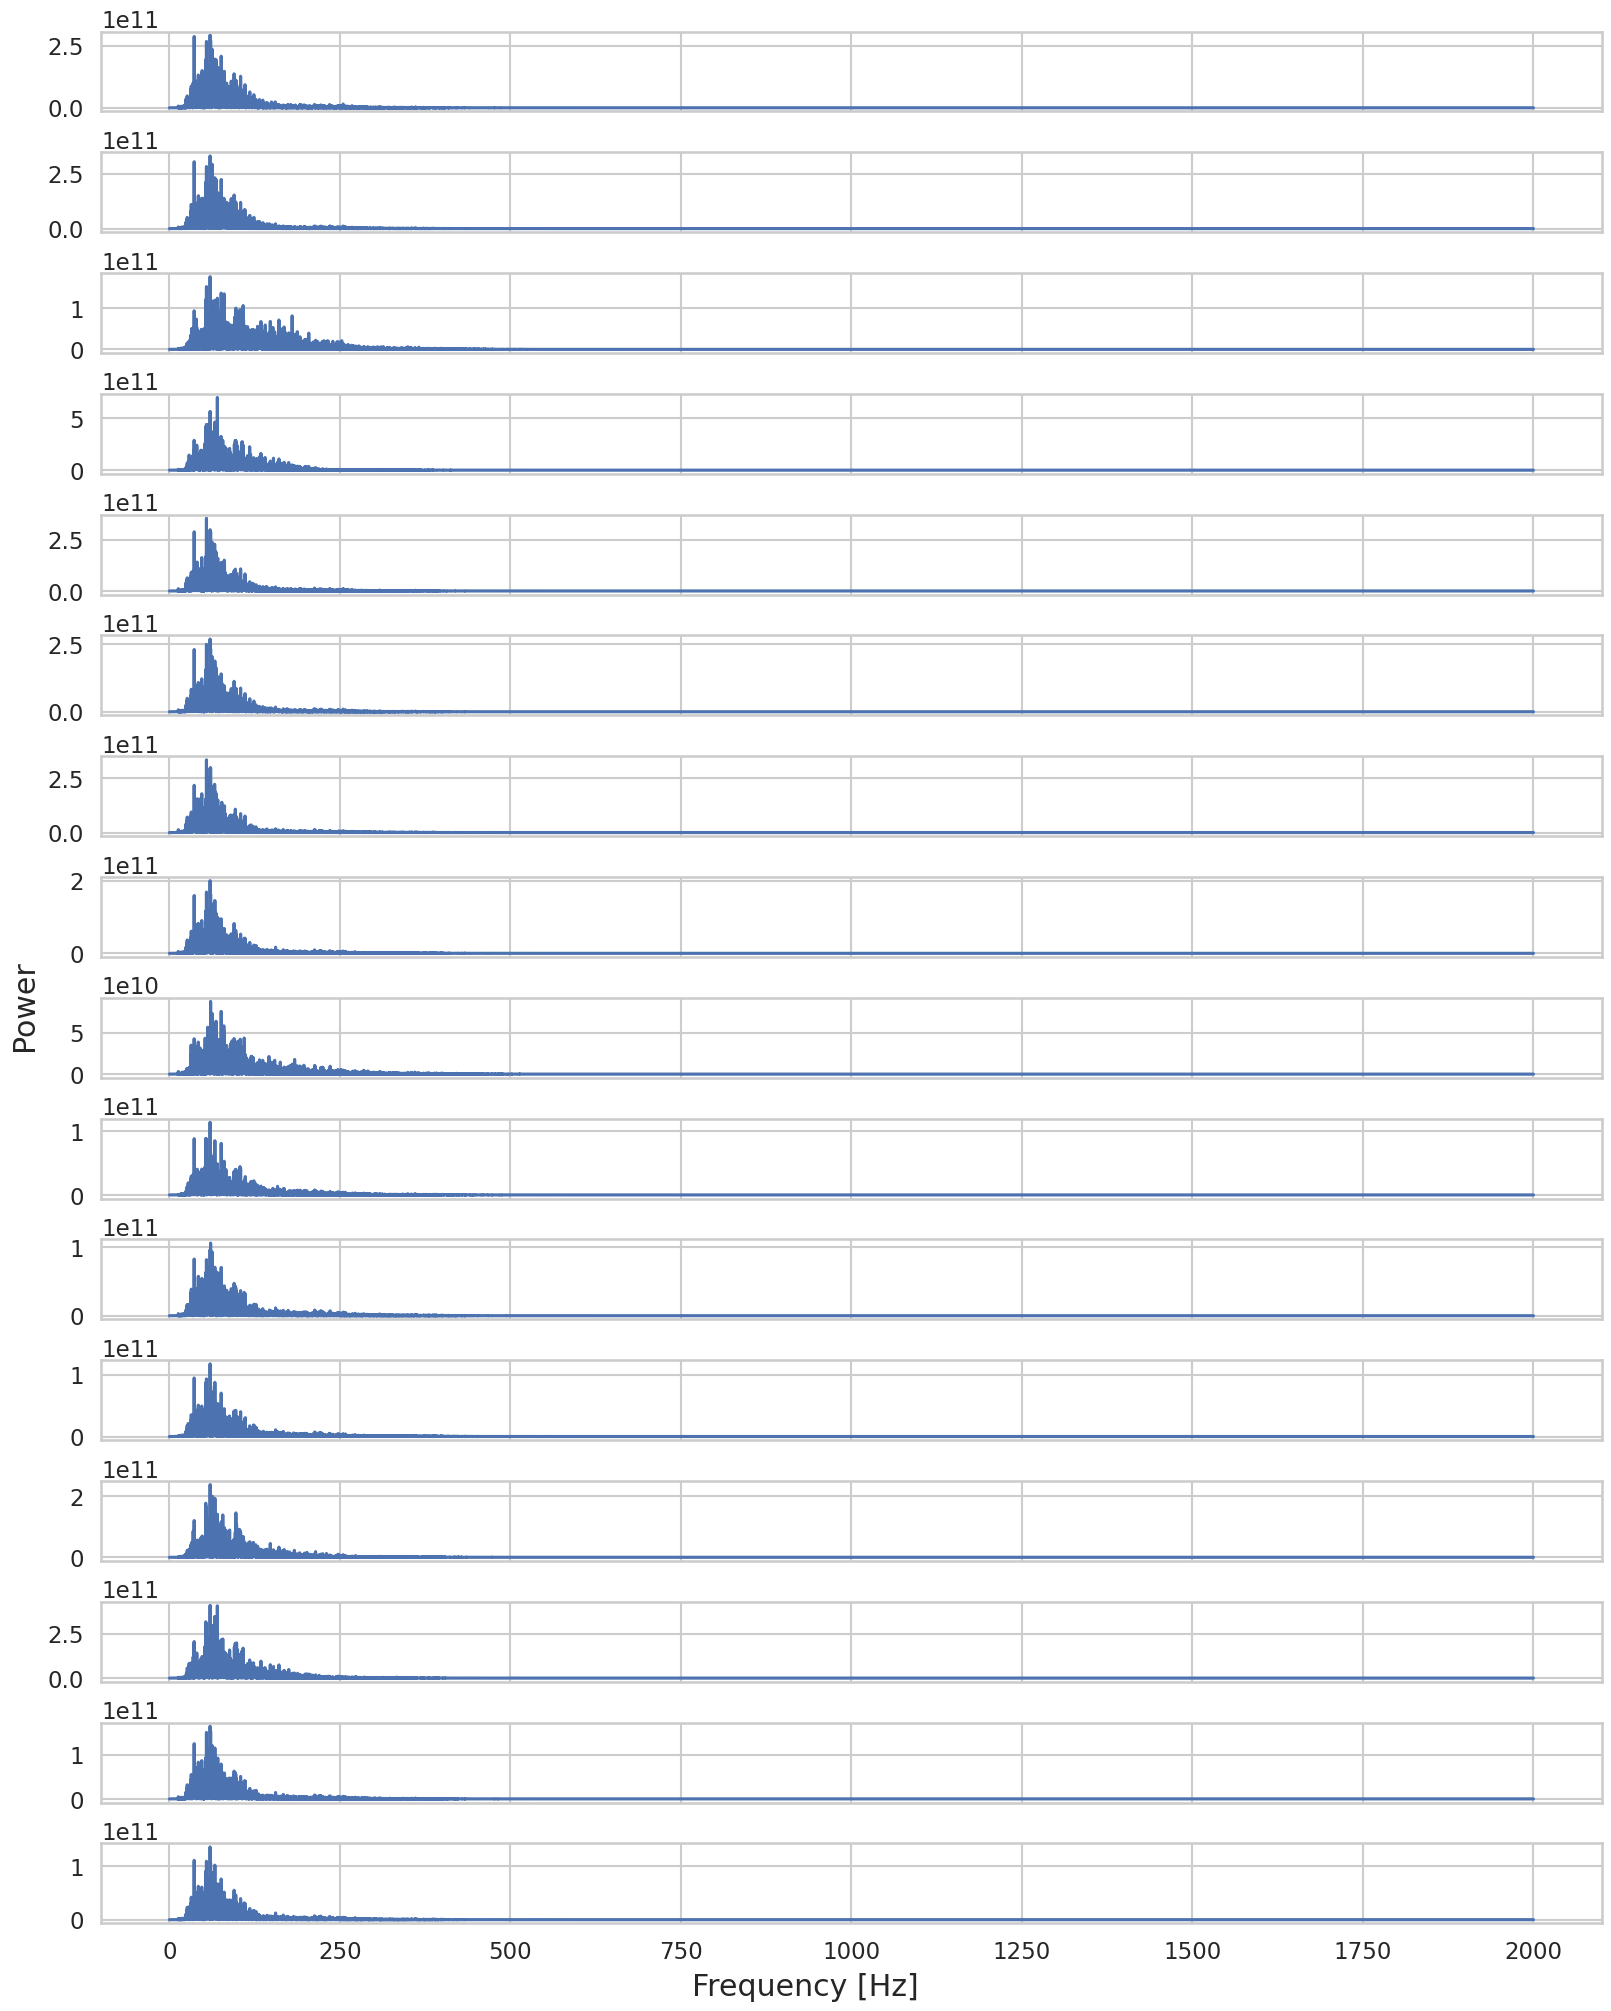

In [2]:
emg = load_armband_signal(DATA_PATH)
labels = emg["Trigger"]
emg = emg.drop(columns="Trigger")
sig_len_s = emg.shape[0] / FS

# Filter
emg_flt = emgkit.preprocessing.bandstop_filter(emg, low_cut=49, high_cut=51, fs=FS)
emg_flt = emgkit.preprocessing.bandpass_filter(emg_flt, low_cut=20, high_cut=500, fs=FS)

power_spectrum = emgkit.utils.power_spectrum(emg_flt, FS)
emgkit.plotting.plot_signal(
    power_spectrum, x_label="Frequency [Hz]", y_label="Power", fig_size=(16, 20)
)

Plot filtered signal and triggers.

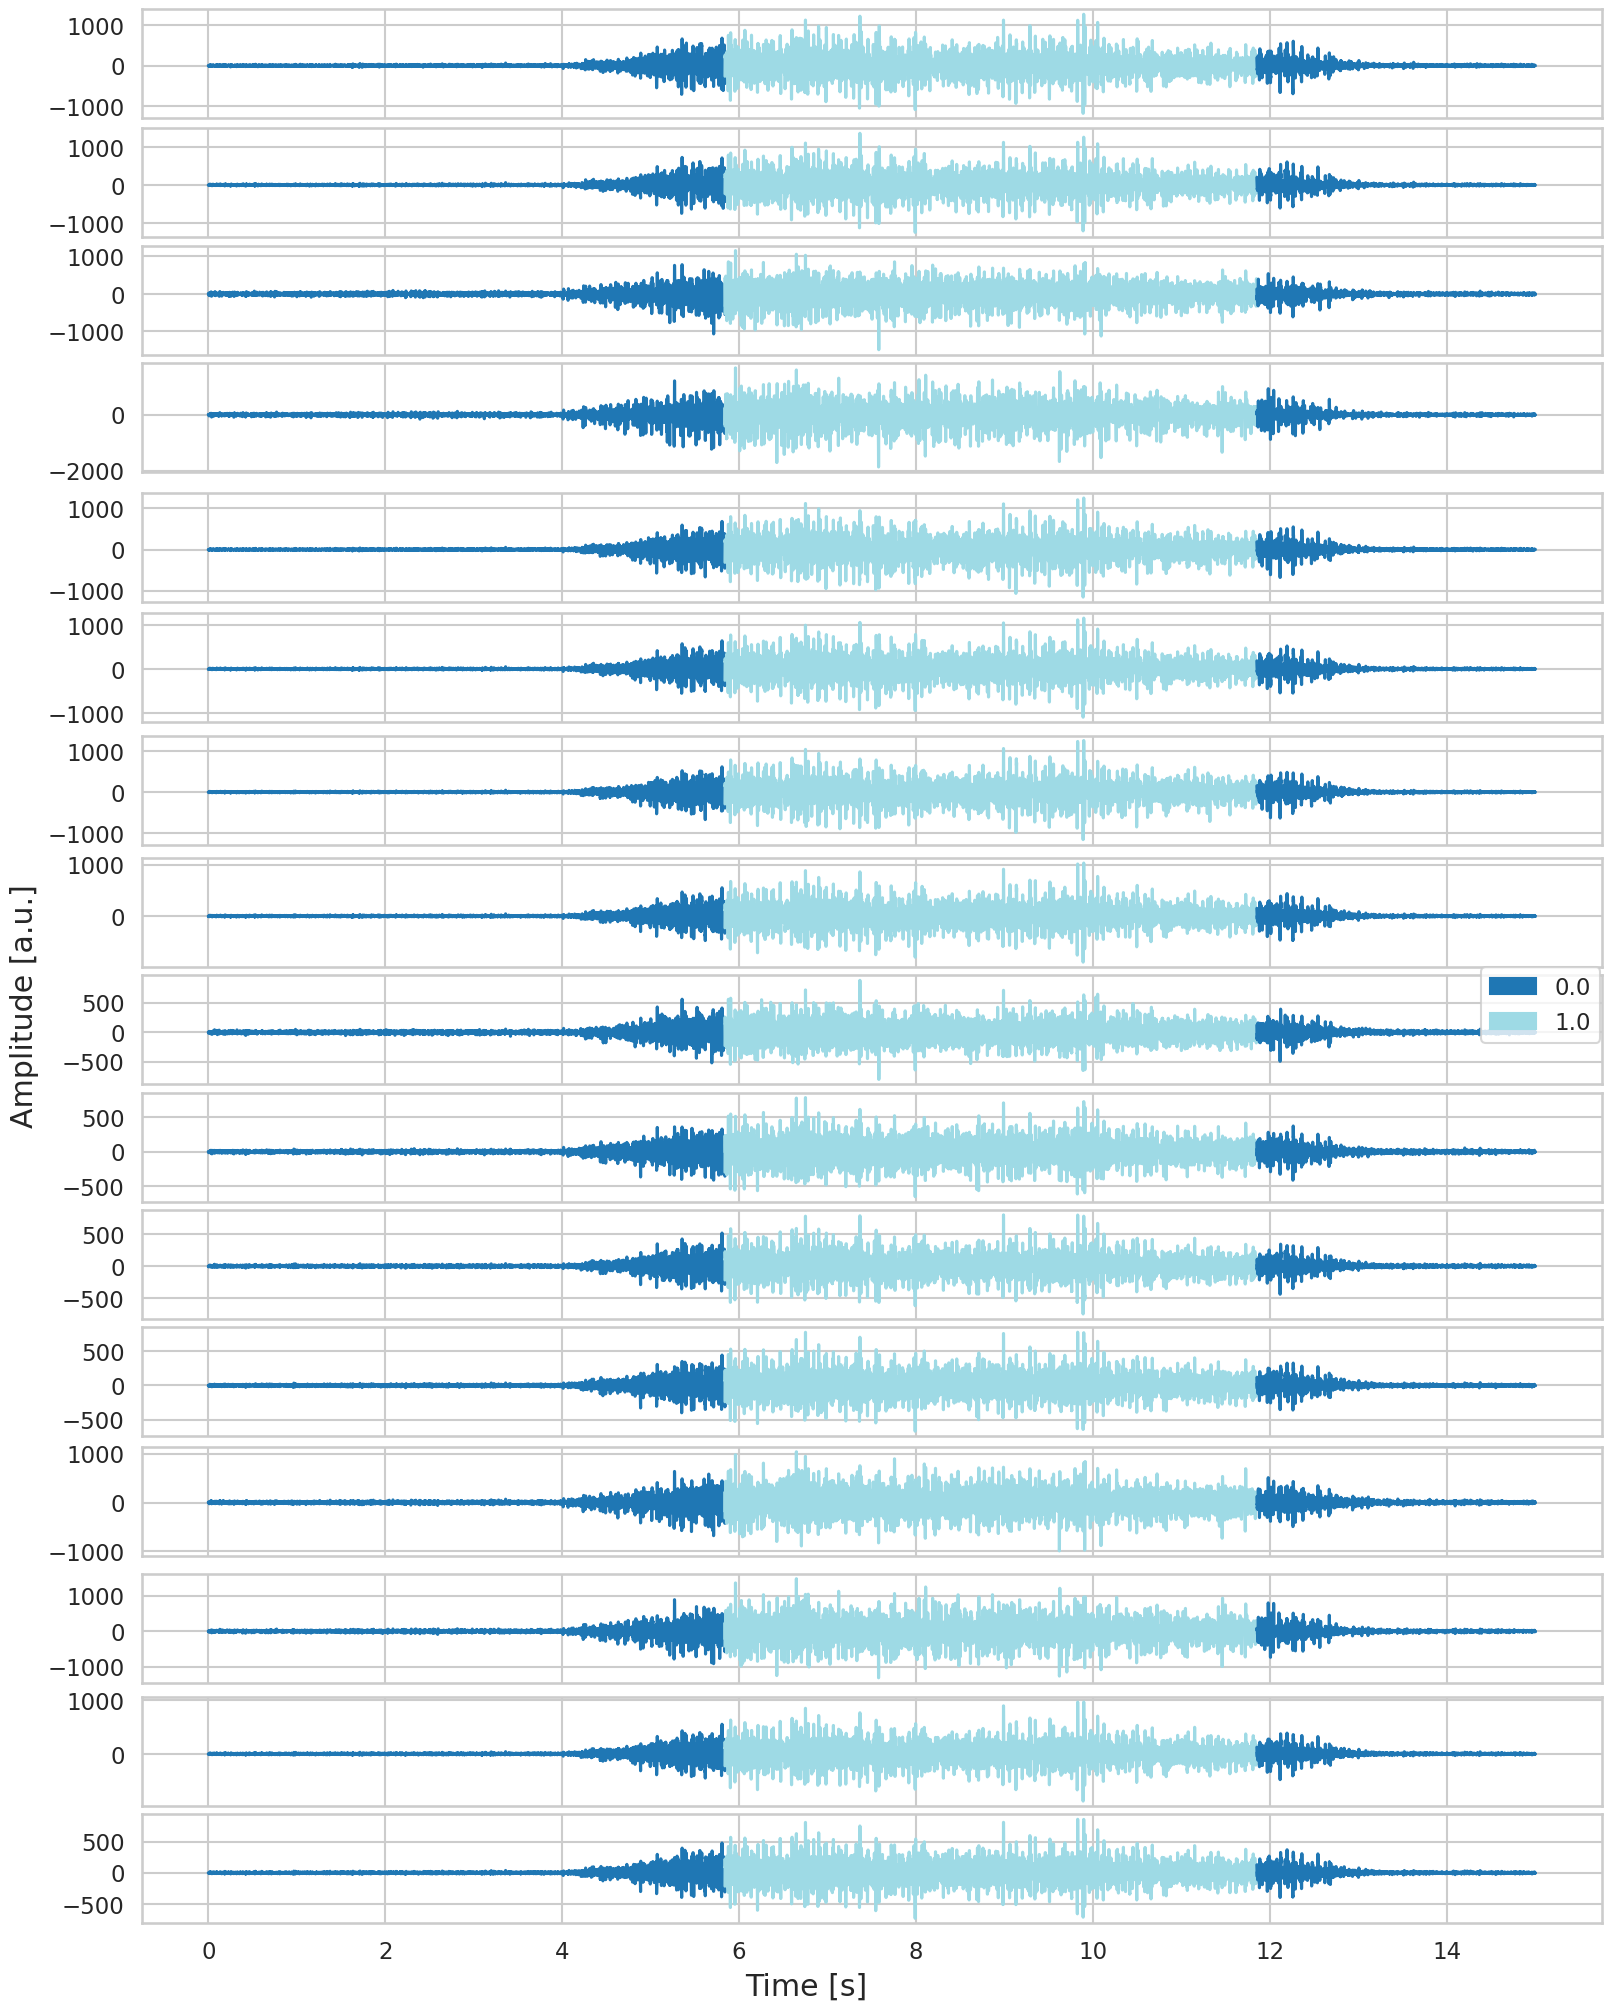

In [3]:
emgkit.plotting.plot_signal(emg_flt, FS, labels, fig_size=(16, 20))

Let's visualize the average RMS.

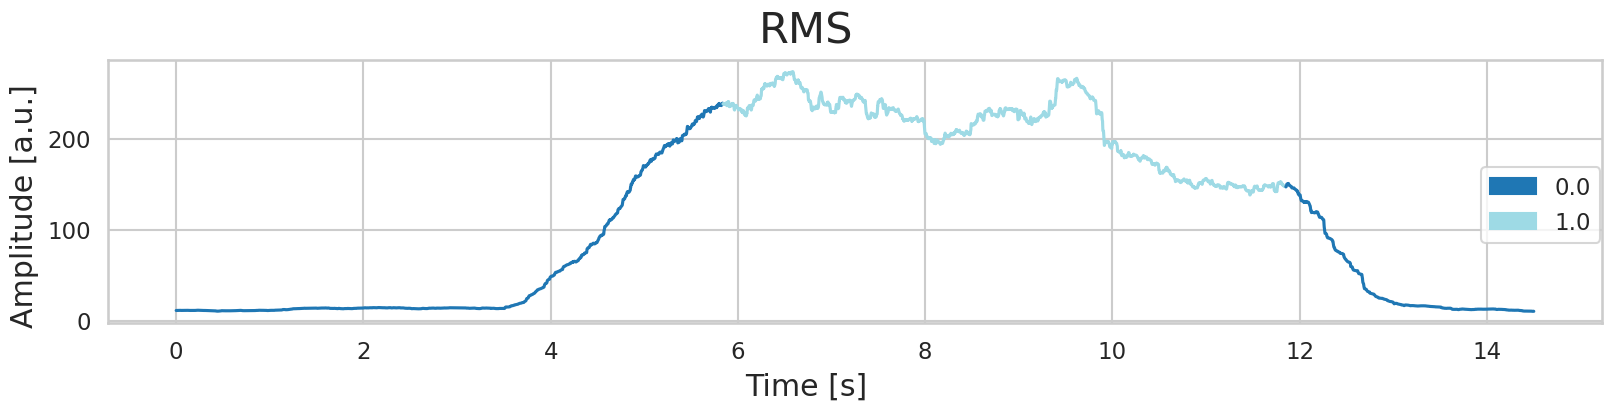

In [4]:
emg_rms = emgkit.features.root_mean_square(emg_flt, win_len_ms=500, fs=FS)
emg_rms = np.mean(emg_rms, axis=1)  # take the mean across channels

emgkit.plotting.plot_signal(emg_rms, FS, labels, title="RMS", fig_size=(16, 4))

Instantiate the decomposition model and perform the MU extraction.

In [5]:
conv_bss = emgkit.decomposition.ConvBSS(
    fs=FS,
    n_mu_target=150,
    sil_th=0.6,
    cov_isi_th=0.6,
    device=device,
    seed=SEED,
)

conv_bss.decompose_training(emg_flt[labels != 0])

ics, spikes_t = conv_bss.decompose_inference(emg_flt)
ext_sig_len_s = ics.shape[0] / FS

INFO:root:Number of channels before extension: 16
INFO:root:Number of channels after extension: 160


INFO:root:----- IC 1 -----
INFO:root:FastICA converged after 31 iterations, the distance is: 8.702e-05.
INFO:root:CoV-ISI increased from 108.29% to 117.21% after 1 steps.
INFO:root:----- IC 2 -----
INFO:root:CoV-ISI increased from 88.84% to 91.06% after 1 steps.
INFO:root:----- IC 3 -----
INFO:root:FastICA converged after 15 iterations, the distance is: 9.376e-05.
INFO:root:CoV-ISI increased from 104.63% to 156.88% after 1 steps.
INFO:root:----- IC 4 -----
INFO:root:FastICA converged after 82 iterations, the distance is: 9.418e-05.
INFO:root:CoV-ISI decreased from 86.06% to 77.42% after 1 steps.
INFO:root:CoV-ISI increased from 77.42% to 86.91% after 2 steps.
INFO:root:----- IC 5 -----
INFO:root:CoV-ISI increased from 78.91% to 83.46% after 1 steps.
INFO:root:----- IC 6 -----
INFO:root:FastICA converged after 54 iterations, the distance is: 8.458e-05.
INFO:root:CoV-ISI decreased from 97.64% to 86.31% after 1 steps.
INFO:root:CoV-ISI decreased from 86.31% to 73.63% after 2 steps.
INFO:r

Plot the ICs spike trains.

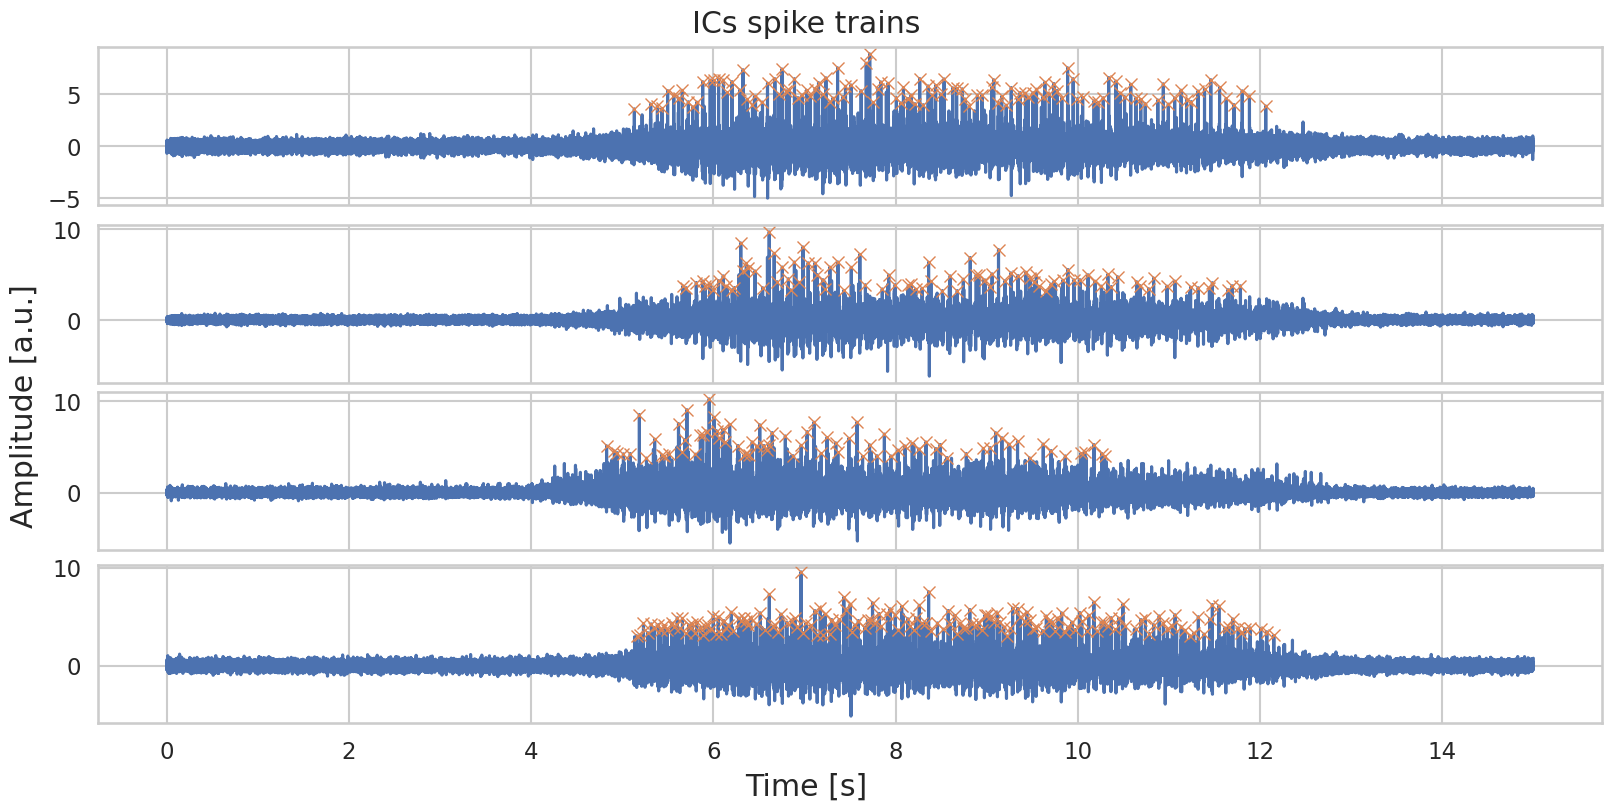

In [6]:
emgkit.plotting.plot_ic_spikes(
    ics, spikes_t, fig_size=(16, 8), file_name=f"{SUBJ}_ic_spikes_iso.svg"
)

Display the raster plot.

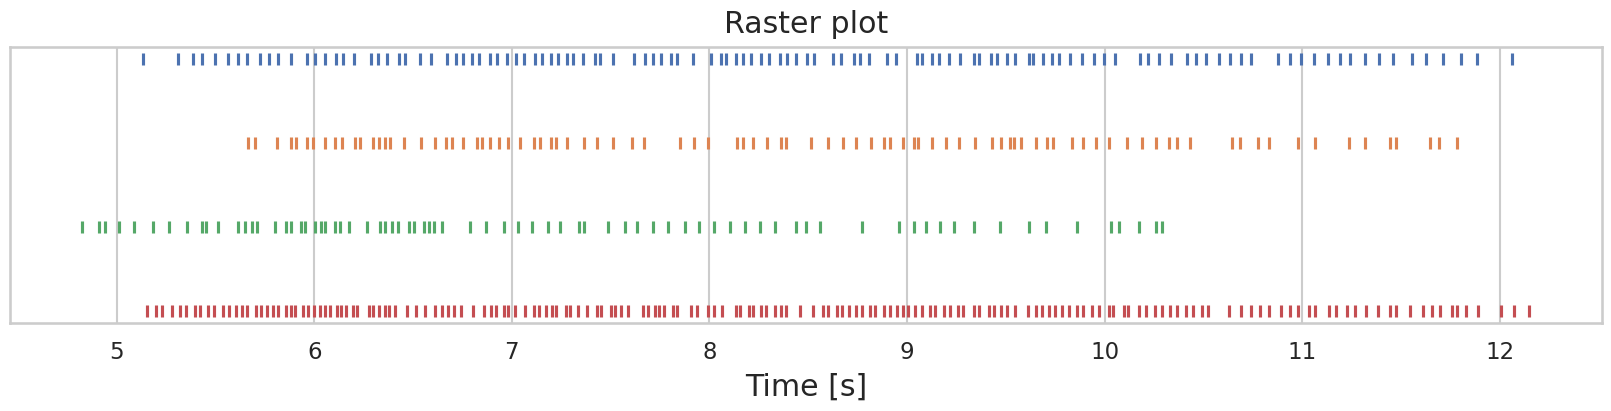

In [7]:
emgkit.plotting.raster_plot(
    spikes_t, fig_size=(16, 4), file_name=f"{SUBJ}_raster_iso.svg"
)

Display the discharge rate.

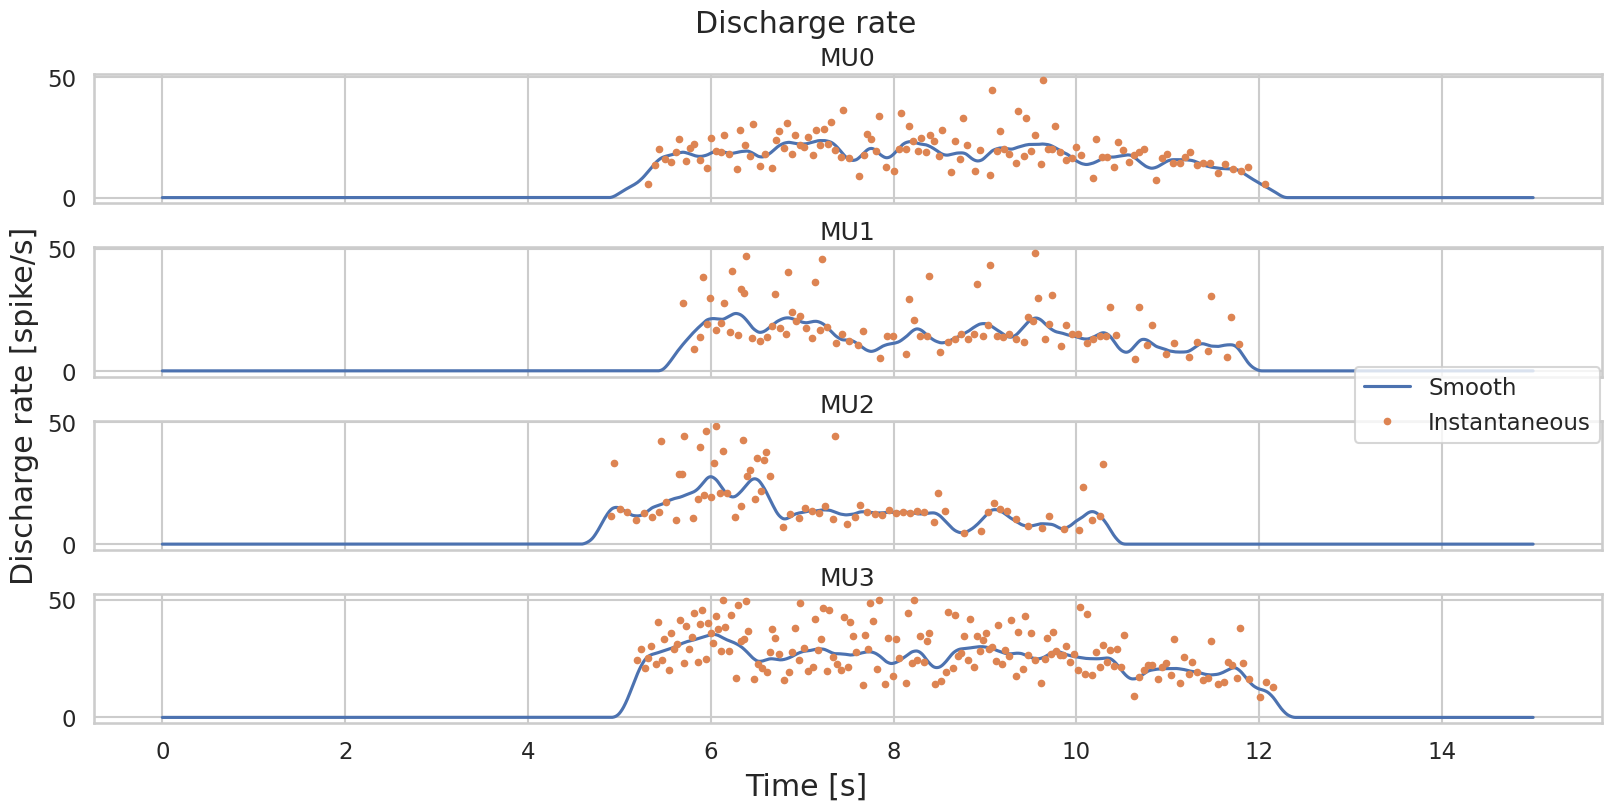

In [8]:
emgkit.plotting.plot_discharges(
    spikes_t,
    ext_sig_len_s,
    FS,
    win_len_s=0.5,
    fig_size=(16, 8),
    file_name=f"{SUBJ}_discharges_iso.svg",
)

Compute the waveforms and plot them.

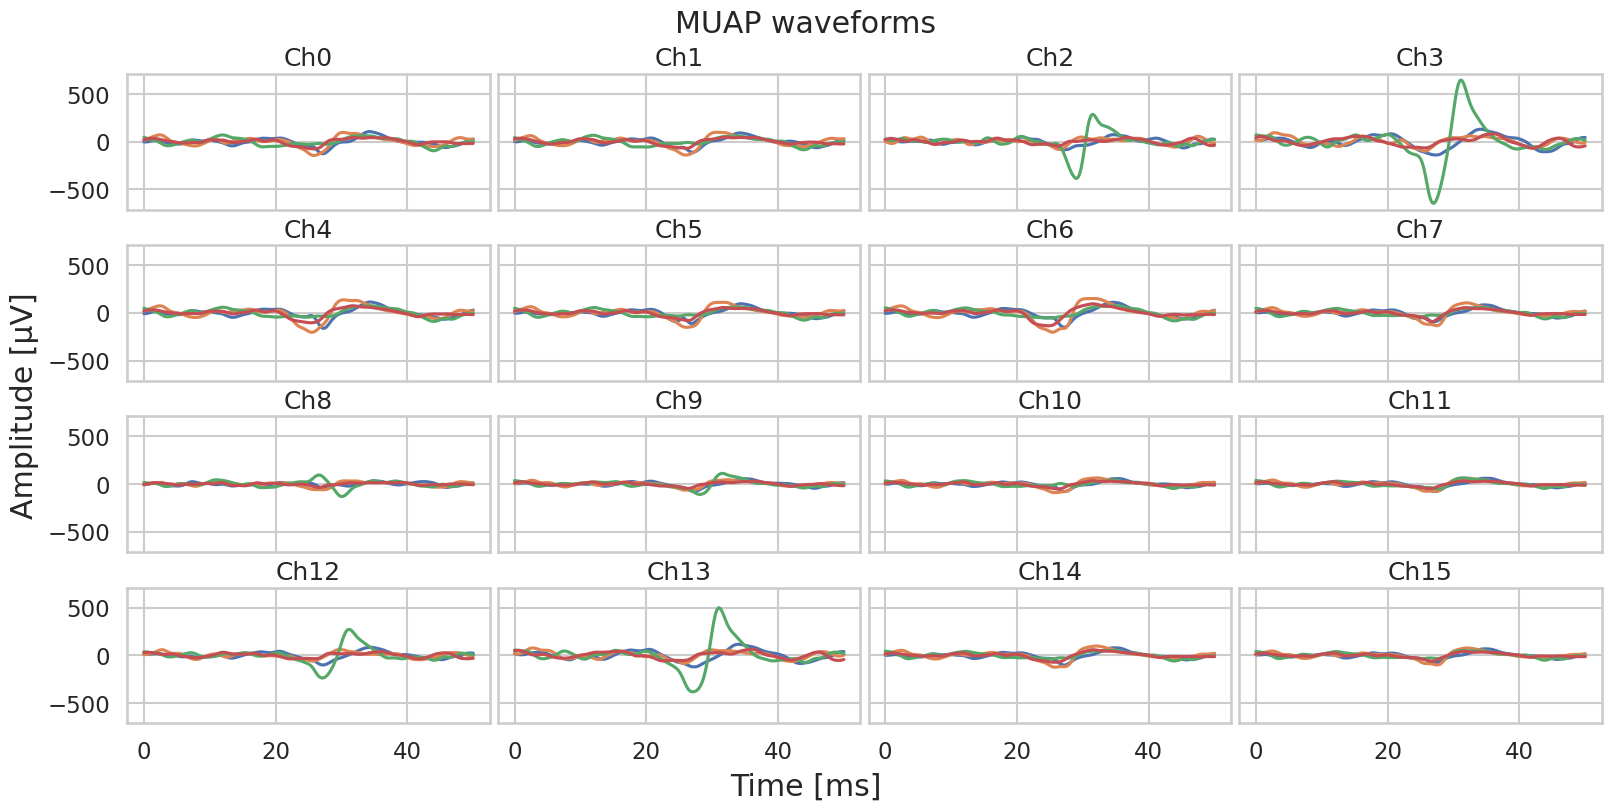

In [9]:
wfs = emgkit.utils.compute_waveforms(emg_flt, spikes_t, wf_radius_ms=25.0, fs=FS)

emgkit.plotting.plot_waveforms(
    wfs,
    fs=FS,
    n_cols=4,
    y_label="Amplitude [\u03BCV]",
    fig_size=(16, 8),
    file_name=f"{SUBJ}_wfs_iso.svg",
)

Finally, save the model to file.

In [10]:
conv_bss.save_to_file(f"iso_model_{SUBJ}.pkl")